In [4]:
%matplotlib inline
import os
import sys
import matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import cmath
import pickle
import time
from collections import defaultdict
import sklearn

from datetime import datetime, date

from sktensor import dtensor, cp_als
# matplotlib.style.use('ggplot')

from sklearn.utils.extmath import randomized_svd
from sklearn.metrics import precision_recall_curve, average_precision_score
from sktensor import dtensor, cp_als


from numpy import linalg as LA

matplotlib.style.use('ggplot')

### Create the tensor

In [2]:
df = pickle.load( open( "dblp_inproceeding_10.p", "rb" ) )
df = df[df.crossref != '']
df.shape

(1296663, 3)

In [3]:
#selected_index = np.random.choice(len(df), int(0.5*len(df)))
#df = df.iloc[selected_index, :]

In [59]:
AUC_CUT_TSVD = []
AUC_CWT_TSVD = []
AUC_CUT_BKatz = []
AUC_CWT_BKatz = []
AUC_CUT_TBKatz = []
AUC_CWT_TBKatz = []

In [5]:
selected_index = np.random.choice(len(df), int(0.5*len(df)))
df = df.iloc[selected_index, :]

### Choose only 10 years

In [82]:
PR_CUT_TSVD = []
PR_CWT_TSVD = []
PR_CUT_BKatz = []
PR_CWT_BKatz = []
PR_CUT_TBKatz = []
PR_CWT_TBKatz = []

In [85]:
for val in range(1,7) :
    print 'Step 1'
    df_train = df[df.year>=1991+val]
    df_train = df[df.year<=2000+val]
    df_test = df[df.year==2001+val]

    df_train.reset_index(inplace=True)
    df2 = df_train.iloc[:,1:]
    df_train = df2
    del df2

    df_train = df_train[df_train.crossref != '']
    df_train.reset_index(inplace=True)
    df2 = df_train.iloc[:,1:]
    df_train = df2
    del df2

    author_list = pd.unique(df_train.iloc[:,0])

    # Get the indexes of each author
    authors_indexes = [(element, index) for index, element in enumerate(df_train.author)]
    author_index = defaultdict(list)

    for k, v in authors_indexes:
        author_index[k].append(v)

    # Keep the authors with more than 10 publications
    author_index_sorted = []
    count = 0

    print 'Step 2'

    for author in author_list : 
        if len(author_index[author]) > 10 :
            author_index_sorted += author_index[author]
            count += len(author_index[author])

    df_train = df_train[df_train.index.isin(author_index_sorted)]
    df_test = df_test[df_test.author.isin(df_train.author)]
    df_test = df_test[df_test.crossref.isin(df_train.crossref)]
    df_train.shape, df_test.shape

    author_list = pd.unique(df_train.iloc[:, 0])
    conf_list = pd.unique(df_train.iloc[:, 2])
    year_list = pd.unique(df_train.iloc[:, 1])
    year_list.sort()

    author_dic = {element : index for index, element in enumerate(author_list)}
    conf_dic =   {element : index for index, element in enumerate(conf_list)}
    year_dic =   {element : index for index, element in enumerate(year_list)}

    T_train = np.zeros((len(author_list), len(conf_list), len(year_list)))
    T_train = dtensor(T_train)

    # Going through the dataframe
    for a, c, y in zip(df_train.author, df_train.crossref, df_train.year):        
        # Finding the corresponding index in the tensor
        a_ind = author_dic[a]
        c_ind = conf_dic[c]
        y_ind = year_dic[y]
        # Modifying the tensor value for the tuple (i_ind, j_ind, k_ind)
        T_train[a_ind, c_ind, y_ind] += 1

    # Logarithmic Transformation
    nonz = T_train.nonzero()
    for ind in range(len(nonz[0])):
        i_ind = nonz[0][ind]
        j_ind = nonz[1][ind] 
        k_ind = nonz[2][ind]  
        T_train[i_ind, j_ind, k_ind] = 1 + np.log(T_train[i_ind, j_ind, k_ind]) 

    print 'Step 3'
    author_list_train = author_list
    conf_list_train = conf_list
    author_dic_train = author_dic
    conf_dic_train = conf_dic

    T_test = np.zeros((len(author_list_train), len(conf_list_train)))

    # Going through the dataframe
    for a, c in zip(df_test.author, df_test.crossref):
        # Finding the corresponding index in the tensor
        a_ind = author_dic_train[a]
        c_ind = conf_dic_train[c]
        # Modifying the tensor value for the tuple (i_ind, j_ind, k_ind)
        T_test[a_ind, c_ind] = 1

    del author_list_train, conf_list_train, author_list, conf_list, author_dic, conf_dic, df_test

    #Proportion of non-zero entries of the tensor
    mail_rate = np.count_nonzero(T_train) / float(T_train.shape[0] * T_train.shape[1] * T_train.shape[2])

    print 'Step 4'
    # CUT
    CUT = np.zeros((T_train[:,:,0].shape[0], T_train[:,:,0].shape[1]))
    for k in range(T_train.shape[2]):
        CUT = CUT + T_train[:,:,k]

    # TSVD
    S_test = (1*np.array(T_test[:, :] >= 1))
    S = np.zeros((CUT.shape[0], CUT.shape[1]))
    tau = 2
    K_list = [1,5,10,30,50]
    for K_ind in range(len(K_list)):
        # Choice of K
        K = K_list[K_ind]
        # TSVD Decomposition
        U, Sigma, Vt = randomized_svd(CUT, n_components=K, n_iter=5, random_state=None)
        # TSVD Scoring
        Sk = np.dot(np.dot(U,np.diag(Sigma)),Vt)
        S+= Sk/LA.norm(Sk, 'fro')
    y_score = S.flatten()
    y_test = S_test.flatten()
    PR_CUT_TSVD += [average_precision_score(y_test, y_score)]

    print 'Step 5'

    # BKatz
    beta = 0.001
    U, Sigma, V= np.linalg.svd(CUT, full_matrices=False)
    S_test = (1*np.array(T_test[:, :] >= 1))
    theta = 0.2
    gamma = []
    for j in range(len(Sigma)) :
        gamma += [1/(1-beta*Sigma[j]) - 1]
    # Katz Scoring
    S = np.dot(np.dot(U,np.diag(gamma)),V)
    y_score = S.flatten()
    y_test = S_test.flatten()
    PR_CUT_BKatz += [average_precision_score(y_test, y_score)]

    print 'Step 6'
    #TBKatz
    beta = 0.001
    S_test = (1*np.array(T_test[:, :] >= 1))
    K_list = [1,5,10,30,50]
    for K_ind in range(len(K_list)) :
        K=K_list[K_ind]
        U, Sigma, Vt= randomized_svd(CUT, n_components=K, n_iter=5, random_state=None)
        gamma = []
        for j in range(K) :
            gamma += [1/(1-beta*Sigma[j]) - 1]
        Sk = np.dot(U,np.dot(np.diag(gamma), Vt))
        S+= Sk/LA.norm(Sk, 'fro')
    y_score = S.flatten()
    y_test = S_test.flatten() 
    PR_CUT_TBKatz += [average_precision_score(y_test, y_score)]

    print 'Step 7'
    # CWT
    CWT = np.zeros((T_train[:,:,0].shape[0], T_train[:,:,0].shape[1]))
    theta = 0.2
    K = T_train.shape[2]
    for k in range(T_train.shape[2]):
        CWT = CWT + ((1-theta)**(K - k))*T_train[:,:,k]
    # Create a np.array matrix instead of the sklearn tensor
    C = np.zeros((T_train[:,:,0].shape[0], T_train[:,:,0].shape[1]))
    for i in range(CWT.shape[0]) :
        for j in range(CWT.shape[1]) :
            C[i,j] = CWT[i,j]
    CWT = C
    del C

    print 'Step 8'
    # TSVD
    S_test = (1*np.array(T_test[:, :] >= 1))
    S = np.zeros((CWT.shape[0], CWT.shape[1]))
    tau = 2
    K_list = [1,5,10,30,50]
    for K_ind in range(len(K_list)):
        # Choice of K
        K = K_list[K_ind]
        # TSVD Decomposition
        U, Sigma, Vt = randomized_svd(CWT, n_components=K, n_iter=5, random_state=None)
        # TSVD Scoring
        Sk = np.dot(np.dot(U,np.diag(Sigma)),Vt)
        S+= Sk/LA.norm(Sk, 'fro')
    y_score = S.flatten()
    y_test = S_test.flatten()
    PR_CWT_TSVD += [average_precision_score(y_test, y_score)]

    print 'Step 9'
    # BKatz
    beta = 0.001
    U, Sigma, V= np.linalg.svd(CWT, full_matrices=False)
    S_test = (1*np.array(T_test[:, :] >= 1))
    theta = 0.2
    gamma = []
    for j in range(len(Sigma)) :
        gamma += [1/(1-beta*Sigma[j]) - 1]
    # Katz Scoring
    S = np.dot(np.dot(U,np.diag(gamma)),V)
    y_score = S.flatten()
    y_test = S_test.flatten()
    PR_CWT_BKatz += [average_precision_score(y_test, y_score)]

    print 'Step 10'
    #TBKatz
    beta = 0.001
    S_test = (1*np.array(T_test[:, :] >= 1))
    K_list = [1,5,10,30,50]
    for K_ind in range(len(K_list)) :
        K=K_list[K_ind]
        U, Sigma, Vt= randomized_svd(CWT, n_components=K, n_iter=5, random_state=None)
        gamma = []
        for j in range(K) :
            gamma += [1/(1-beta*Sigma[j]) - 1]
        Sk = np.dot(U,np.dot(np.diag(gamma), Vt))
        S+= Sk/LA.norm(Sk, 'fro')
    y_score = S.flatten()
    y_test = S_test.flatten()
    PR_CWT_TBKatz += [average_precision_score(y_test, y_score)]

    print 'Done'

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Done
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Done
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Done
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Done
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Done
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Done


In [86]:
len(PR_CWT_TBKatz)

7

In [88]:
print PR_CUT_TSVD, sum(PR_CUT_TSVD)/len(PR_CUT_TSVD)
print PR_CUT_BKatz, sum(PR_CUT_BKatz)/len(PR_CUT_BKatz)
print PR_CUT_TBKatz, sum(PR_CUT_TBKatz)/len(PR_CUT_TBKatz)

print PR_CWT_TSVD, sum(PR_CWT_TSVD)/len(PR_CWT_TSVD) 
print PR_CWT_BKatz, sum(PR_CWT_BKatz)/len(PR_CWT_BKatz) 
print PR_CWT_TBKatz, sum(PR_CWT_TBKatz)/len(PR_CWT_TBKatz)

[0.054300037481912158, 0.054581659095141212, 0.053355539334328198, 0.047592995698103074, 0.046110251611207936, 0.047347362396661305, 0.04667452588810049] 0.0499946245008
[0.095673770981927919, 0.096214519420387293, 0.097399344679387642, 0.091740856306382082, 0.090641586823755865, 0.091608488458066156, 0.092173589774506792] 0.0936360223492
[0.059303401750437038, 0.061111103122946576, 0.061768029284650895, 0.05815337926305246, 0.057138782222836748, 0.058527365059168272, 0.059467327124047106] 0.0593527696896
[0.040546726757160888, 0.050372223432093403, 0.05487136625092915, 0.052221202579869515, 0.055760262910405506, 0.064793265873821504, 0.06897285278179488] 0.0553625572266
[0.068375812833104913, 0.091841102030741917, 0.10601657021631541, 0.11133053827126536, 0.11637880718693008, 0.11879298210906825, 0.12158694730393395] 0.104903251422
[0.044777626489436957, 0.05482251774506422, 0.06037131998413061, 0.060285092851028843, 0.063845372875051473, 0.07294034289294378, 0.078308440345595809] 0.0

In [89]:
print sum(PR_CUT_TSVD)/len(PR_CUT_TSVD)
print sum(PR_CUT_BKatz)/len(PR_CUT_BKatz)
print sum(PR_CUT_TBKatz)/len(PR_CUT_TBKatz)

print sum(PR_CWT_TSVD)/len(PR_CWT_TSVD) 
print sum(PR_CWT_BKatz)/len(PR_CWT_BKatz) 
print sum(PR_CWT_TBKatz)/len(PR_CWT_TBKatz)

0.0499946245008
0.0936360223492
0.0593527696896
0.0553625572266
0.104903251422
0.0621929590262


In [62]:
 
for val in range(1,7):
    print 'Step 1'
    df_train = df[df.year>=1991+val]
    df_train = df[df.year<=2000+val]
    df_test = df[df.year==2001+val]

    df_train.reset_index(inplace=True)
    df2 = df_train.iloc[:,1:]
    df_train = df2
    del df2

    df_train = df_train[df_train.crossref != '']
    df_train.reset_index(inplace=True)
    df2 = df_train.iloc[:,1:]
    df_train = df2
    del df2

    author_list = pd.unique(df_train.iloc[:,0])

    # Get the indexes of each author
    authors_indexes = [(element, index) for index, element in enumerate(df_train.author)]
    author_index = defaultdict(list)

    for k, v in authors_indexes:
        author_index[k].append(v)

    # Keep the authors with more than 10 publications
    author_index_sorted = []
    count = 0

    print 'Step 2'

    for author in author_list : 
        if len(author_index[author]) > 10 :
            author_index_sorted += author_index[author]
            count += len(author_index[author])

    df_train = df_train[df_train.index.isin(author_index_sorted)]
    df_test = df_test[df_test.author.isin(df_train.author)]
    df_test = df_test[df_test.crossref.isin(df_train.crossref)]
    df_train.shape, df_test.shape

    author_list = pd.unique(df_train.iloc[:, 0])
    conf_list = pd.unique(df_train.iloc[:, 2])
    year_list = pd.unique(df_train.iloc[:, 1])
    year_list.sort()

    author_dic = {element : index for index, element in enumerate(author_list)}
    conf_dic =   {element : index for index, element in enumerate(conf_list)}
    year_dic =   {element : index for index, element in enumerate(year_list)}

    T_train = np.zeros((len(author_list), len(conf_list), len(year_list)))
    T_train = dtensor(T_train)

    # Going through the dataframe
    for a, c, y in zip(df_train.author, df_train.crossref, df_train.year):        
        # Finding the corresponding index in the tensor
        a_ind = author_dic[a]
        c_ind = conf_dic[c]
        y_ind = year_dic[y]
        # Modifying the tensor value for the tuple (i_ind, j_ind, k_ind)
        T_train[a_ind, c_ind, y_ind] += 1

    # Logarithmic Transformation
    nonz = T_train.nonzero()
    for ind in range(len(nonz[0])):
        i_ind = nonz[0][ind]
        j_ind = nonz[1][ind] 
        k_ind = nonz[2][ind]  
        T_train[i_ind, j_ind, k_ind] = 1 + np.log(T_train[i_ind, j_ind, k_ind]) 

    print 'Step 3'
    author_list_train = author_list
    conf_list_train = conf_list
    author_dic_train = author_dic
    conf_dic_train = conf_dic

    T_test = np.zeros((len(author_list_train), len(conf_list_train)))

    # Going through the dataframe
    for a, c in zip(df_test.author, df_test.crossref):
        # Finding the corresponding index in the tensor
        a_ind = author_dic_train[a]
        c_ind = conf_dic_train[c]
        # Modifying the tensor value for the tuple (i_ind, j_ind, k_ind)
        T_test[a_ind, c_ind] = 1

    del author_list_train, conf_list_train, author_list, conf_list, author_dic, conf_dic, df_test

    #Proportion of non-zero entries of the tensor
    mail_rate = np.count_nonzero(T_train) / float(T_train.shape[0] * T_train.shape[1] * T_train.shape[2])


    print 'Step 7'
    # CWT
    CWT = np.zeros((T_train[:,:,0].shape[0], T_train[:,:,0].shape[1]))
    theta = 0.2
    K = T_train.shape[2]
    for k in range(T_train.shape[2]):
        CWT = CWT + ((1-theta)**(K - k))*T_train[:,:,k]
    # Create a np.array matrix instead of the sklearn tensor
    C = np.zeros((T_train[:,:,0].shape[0], T_train[:,:,0].shape[1]))
    for i in range(CWT.shape[0]) :
        for j in range(CWT.shape[1]) :
            C[i,j] = CWT[i,j]
    CWT = C
    del C

    print 'Step 8'
    # TSVD
    S_test = (1*np.array(T_test[:, :] >= 1))
    S = np.zeros((CWT.shape[0], CWT.shape[1]))
    tau = 2
    K_list = [1,5,10,30,50]
    for K_ind in range(len(K_list)):
        # Choice of K
        K = K_list[K_ind]
        # TSVD Decomposition
        U, Sigma, Vt = randomized_svd(CWT, n_components=K, n_iter=5, random_state=None)
        # TSVD Scoring
        Sk = np.dot(np.dot(U,np.diag(Sigma)),Vt)
        S+= Sk/LA.norm(Sk, 'fro')
    y_score = S.flatten()
    y_test = S_test.flatten()
    AUC_CWT_TSVD += [sklearn.metrics.roc_auc_score(y_test, y_score)]

    print 'Step 9'
    # BKatz
    beta = 0.001
    U, Sigma, V= np.linalg.svd(CWT, full_matrices=False)
    S_test = (1*np.array(T_test[:, :] >= 1))
    theta = 0.2
    gamma = []
    for j in range(len(Sigma)) :
        gamma += [1/(1-beta*Sigma[j]) - 1]
    # Katz Scoring
    S = np.dot(np.dot(U,np.diag(gamma)),V)
    y_score = S.flatten()
    y_test = S_test.flatten()
    AUC_CWT_BKatz += [sklearn.metrics.roc_auc_score(y_test, y_score)]

    print 'Step 10'
    #TBKatz
    beta = 0.001
    S_test = (1*np.array(T_test[:, :] >= 1))
    K_list = [1,5,10,30,50]
    for K_ind in range(len(K_list)) :
        K=K_list[K_ind]
        U, Sigma, Vt= randomized_svd(CWT, n_components=K, n_iter=5, random_state=None)
        gamma = []
        for j in range(K) :
            gamma += [1/(1-beta*Sigma[j]) - 1]
        Sk = np.dot(U,np.dot(np.diag(gamma), Vt))
        S+= Sk/LA.norm(Sk, 'fro')
    y_score = S.flatten()
    y_test = S_test.flatten()
    AUC_CWT_TBKatz += [sklearn.metrics.roc_auc_score(y_test, y_score)]

    print 'Done'

Step 1
Step 2
Step 3
Step 7
Step 8
Step 9
Step 10
Done
Step 1
Step 2
Step 3
Step 7
Step 8
Step 9
Step 10
Done
Step 1
Step 2
Step 3
Step 7
Step 8
Step 9
Step 10
Done
Step 1
Step 2
Step 3
Step 7
Step 8
Step 9
Step 10
Done
Step 1
Step 2
Step 3
Step 7
Step 8
Step 9
Step 10
Done
Step 1
Step 2
Step 3
Step 7
Step 8
Step 9
Step 10
Done


In [63]:
print  AUC_CWT_TSVD, AUC_CWT_BKatz,  AUC_CWT_TBKatz

[0.80803651850554015, 0.79539943358915388, 0.77592201072192335, 0.75628528423868047, 0.73651110206053705, 0.73388498183549589, 0.72751954737693736] [0.73786150685115648, 0.72805603660015672, 0.72191589358075792, 0.71376580580594828, 0.70993642257254641, 0.7104536807099372, 0.71753524376021272] [0.84055450786729491, 0.83479157795817915, 0.82038200458419785, 0.79995675737445959, 0.78901800217278195, 0.80069806025094903, 0.79001760668533039]


In [65]:
print 'AUC_CUT_TSVD', sum(AUC_CUT_TSVD)/len(AUC_CUT_TSVD)
print 'AUC_CWT_TSVD', sum(AUC_CWT_TSVD)/len(AUC_CWT_TSVD)
print 'AUC_CUT_BKatz',sum(AUC_CUT_BKatz)/len(AUC_CUT_BKatz)
print 'AUC_CWT_TSVD', sum(AUC_CWT_TSVD)/len(AUC_CWT_TSVD)
print 'AUC_CWT_BKatz',sum(AUC_CWT_BKatz)/len(AUC_CWT_BKatz)
print 'AUC_CWT_TBKatz',sum(AUC_CWT_TBKatz)/len(AUC_CWT_TBKatz)

AUC_CUT_TSVD 0.752548941985
AUC_CWT_TSVD 0.761936982618
AUC_CUT_BKatz 0.727467558824
AUC_CWT_TSVD 0.761936982618
AUC_CWT_BKatz 0.719932084269
AUC_CWT_TBKatz 0.810774073842


In [32]:
print AUC_CUT_TSVD, AUC_CWT_TSVD, AUC_CUT_BKatz, AUC_CWT_BKatz, AUC_CUT_TBKatz, AUC_CWT_TBKatz

[0.80493644555357446, 0.79366892127593069, 0.76807600023919265, 0.73628282001641787, 0.72721523900826557, 0.72277264637262839, 0.71489052142588483] [0.46646258727993362, 0.46302856178230889, 0.45690197848580888, 0.45899956666244246, 0.4530391949208627, 0.4521393659973949, 0.45035946973877083] [0.74706088783793778, 0.74091629975353257, 0.72889291606285, 0.72086611217663321, 0.71495795000583051, 0.71762934268108025, 0.72194940324767343] [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5] [0.85058261822531256, 0.82895934417707229, 0.81877628582269291, 0.79402122411048837, 0.7847893462085076, 0.78614481236569922, 0.78119183196679265] [0.46646258727993362, 0.46302856178230889, 0.45690197848580888, 0.45899956666244246, 0.4530391949208627, 0.4521393659973949, 0.45035946973877083]


In [66]:
print 'AUC_CUT_TSVD', sum(AUC_CUT_TSVD)/len(AUC_CUT_TSVD)
print 'AUC_CWT_TSVD', sum(AUC_CWT_TSVD)/len(AUC_CWT_TSVD)
print 'AUC_CUT_BKatz',sum(AUC_CUT_BKatz)/len(AUC_CUT_BKatz)
print 'AUC_CWT_BKatz',sum(AUC_CWT_BKatz)/len(AUC_CWT_BKatz)
print 'AUC_CUT_TBKatz',sum(AUC_CUT_TBKatz)/len(AUC_CUT_TBKatz)
print 'AUC_CWT_TBKatz',sum(AUC_CWT_TBKatz)/len(AUC_CWT_TBKatz)

AUC_CUT_TSVD 0.752548941985
AUC_CWT_TSVD 0.761936982618
AUC_CUT_BKatz 0.727467558824
AUC_CWT_BKatz 0.719932084269
AUC_CUT_TBKatz 0.806352208982
AUC_CWT_TBKatz 0.810774073842


In [34]:
L = [0.752548941985, 0.457275817838, 0.727467558824, 0.5, 0.806352208982, 0.457275817838]

In [68]:
L_ = [0.752548941985, 0.727467558824, 0.806352208982, 0.761936982618, 0.719932084269, 0.810774073842]

In [69]:
L_

[0.752548941985,
 0.727467558824,
 0.806352208982,
 0.761936982618,
 0.719932084269,
 0.810774073842]

In [90]:
prec_rec = [0.0499946245008,
0.0936360223492,
0.0593527696896,
0.0553625572266,
0.104903251422,
0.0621929590262]

In [108]:
result = pd.DataFrame({'AUC' : pd.Series(L_, index=['CP', 'TSVD CUT', 'BKatz CUT','TBKatz CUT', 'TSVD CWT', 'BKatz CWT', 'TBKatz CWT'])})

In [106]:
L_=[0.723335] + L_
L_

[0.723335,
 0.752548941985,
 0.727467558824,
 0.806352208982,
 0.761936982618,
 0.719932084269,
 0.810774073842]

In [1]:
p=[.43,.28,.15,.3]

In [5]:
m = pd.DataFrame({'30 days' : p}, index=['TSVD CUT', 'TSVD CWT', 'Katz CUT','Katz CWT'])

In [6]:
m

,30 days
TSVD CUT,0.43
TSVD CWT,0.28
Katz CUT,0.15
Katz CWT,0.30


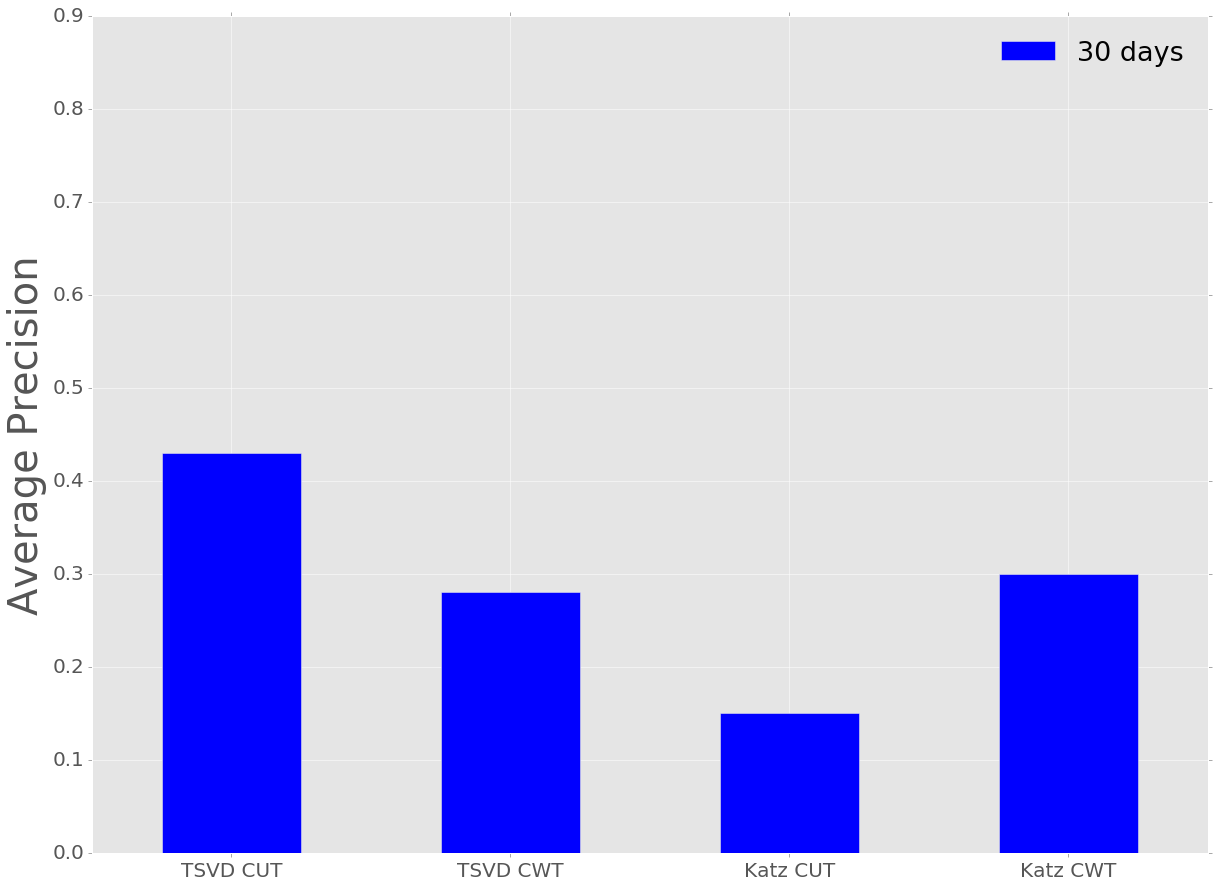

In [7]:
ax = m.plot(kind='bar', figsize=(20,15),legend=True, fontsize=20, rot=0) 
ax.set_ylabel("Average Precision",fontsize=40)
#ax.set_title("Sign Prediction Accuracy across balanced datasets", fontsize=40)
ax.set_ylim([0, 0.9])
ax.legend(fontsize=27, frameon=False) 
#plt.show() 
plt.savefig('PR_30_days_results.pdf')

In [51]:
L2 =[0.711, 0.76,0.694, 0.444,0.5,0.444]
len(L2)

6

In [52]:
result2 = pd.DataFrame({'AUC' : pd.Series(L2, index=['TSVD CUT', 'BKatz CUT','TBKatz CUT', 'TSVD CWT', 'BKatz CWT', 'TBKatz CWT'])})

In [57]:
result

,AUC
TSVD CUT,0.752549
BKatz CUT,0.727468
TBKatz CUT,0.806352
TSVD CWT,0.457276
BKatz CWT,0.500000
TBKatz CWT,0.457276


In [58]:
result2

,AUC
TSVD CUT,0.711
BKatz CUT,0.760
TBKatz CUT,0.694
TSVD CWT,0.444
BKatz CWT,0.500
TBKatz CWT,0.444


### CanDecom/ParaFac (CP) Decomposition

In [23]:
# Defining a function for the outer product of several vectors
def Outer(vecs):
    # vecs can be either a list of vectors (n vectors of dimensions (**,1)) or an array of dimensions (**, n)
    vec_list = []
    if isinstance(vecs, list):
        vec_list = vecs
    elif isinstance(vecs, np.ndarray):
        vec_list = [vecs[:, j] for j in range(vecs.shape[1])]        

    res = reduce(np.multiply, np.ix_(*vec_list))
    return res

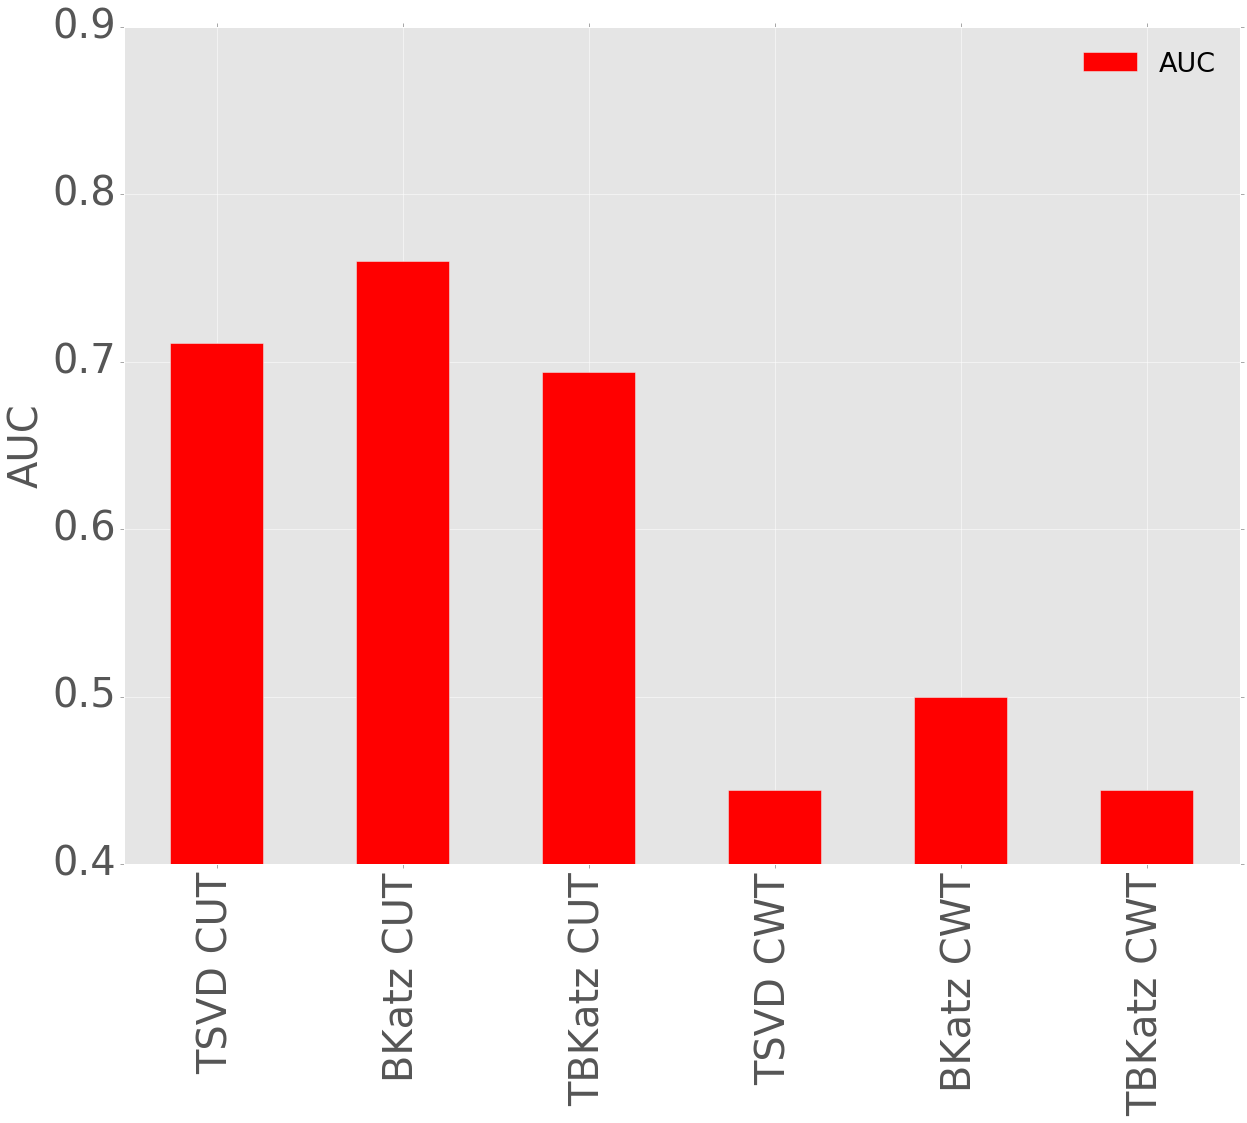

In [53]:
ax = result2.plot(kind='bar', figsize=(20,15),legend=True, fontsize=40, color = 'Red') 
ax.set_ylabel("AUC",fontsize=40)
#ax.set_title("Sign Prediction Accuracy across balanced datasets", fontsize=40)
ax.set_ylim([0.4, 0.9])
ax.legend(fontsize=27, frameon=False) 
# plt.show() plt.savefig('../big_signed_accuracy.pdf')

### Collapsed Unweighted Tensor  
Precision-Recall for several values of K

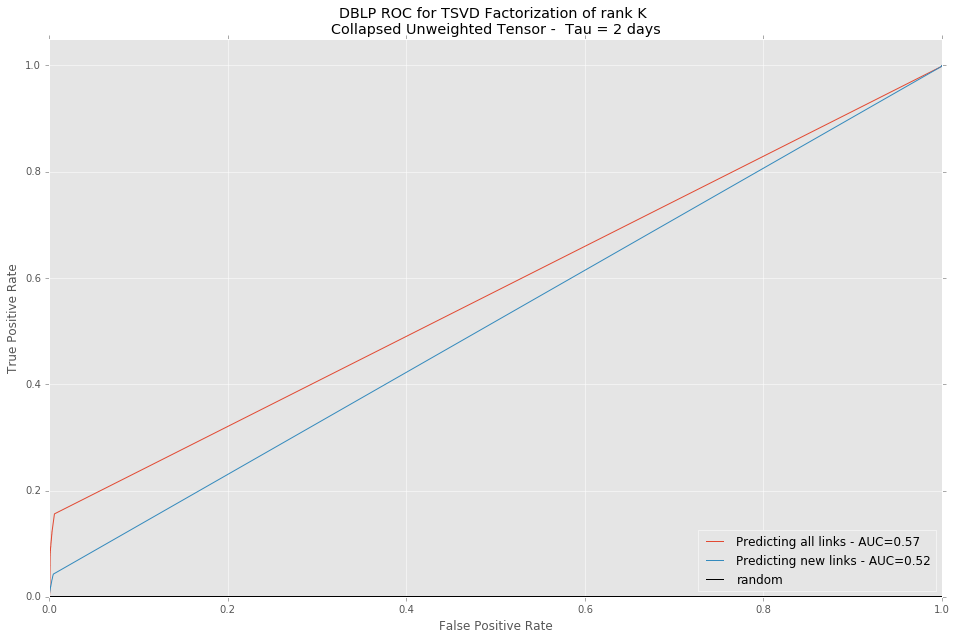

In [25]:
S_test = (1*np.array(T_test[:, :] >= 1))
S = np.zeros((T_train.shape[0], T_train.shape[1]))
S_pred = np.zeros((S.shape[0], S.shape[1]))
S_test_all = np.zeros((S.shape[0], S.shape[1]))

#S_test = np.zeros((CUT.shape[0], CUT.shape[1]))

tau = 2
K_list = [5]
#,5,10,30,50]
FPR = {}
TPR = {}
AUC = {}

S_test = (1*np.array(T_test[:, :] >= 1))

for i in range(2) :
    if i==0 :
        for K_ind in range(len(K_list)):
            K = K_list[K_ind]
            # CP Decomposition
            P, fit, itr, exectimes = cp_als(T_train, K, init='random')
            A, B, C = P.U
            # CP Scoring
            gamma = sum(C[-tau:, :], 0)  # The temporal coefficient
            Sk = sum(map(lambda x: gamma[x]*P.lmbda[x]*Outer([A[:, x], B[:, x]]), range(K)))
            S+= Sk/LA.norm(Sk, 'fro')
        y_test = S_test.flatten()
        y_score = S.flatten()
    else :
        nonz = T_train.nonzero()
        for ind in range(len(nonz[0])):
            i_ind = nonz[0][ind]
            j_ind = nonz[1][ind] 
            S[i_ind, j_ind] = 0
        y_score = S.flatten()
        y_test = S_test.flatten()
            
    # ROC 
    FPR[i], TPR[i], _ = sklearn.metrics.roc_curve(y_test, y_score)
    AUC[i] = sklearn.metrics.roc_auc_score(y_test, y_score)
    
# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))
plt.plot(FPR[0], TPR[0], label='Predicting all links - AUC={0:0.2f}' .format(AUC[0]))
plt.plot(FPR[1], TPR[1], label= 'Predicting new links - AUC={0:0.2f}'.format(AUC[1]))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('DBLP ROC for TSVD Factorization of rank K \nCollapsed Unweighted Tensor -  Tau = %d days' %(tau))
plt.savefig('DBLP TSVD_roc_cut.pdf')   

### Exponential Smoothing  
Precision-Recall for several values of K

In [ ]:
K_list = [1, 5, 10, 30, 50]
#tau_list = [1, 7, 20]
tau_list = [60]
#alpha_list = [0.2, 0.5, 0.8]
alpha_list = [0.3] 

for alpha_ind in range(len(alpha_list)):
    # Choice of alpha
    alpha = alpha_list[alpha_ind]
    for tau_ind in range(len(tau_list)):
        # Choice of tau
        tau = tau_list[tau_ind]

        for K_ind in range(len(K_list)):
            # Choice of K
            K = K_list[K_ind]
            # CP Decomposition
            P, fit, itr, exectimes = cp_als(T_train, K, init='random')
            A, B, C = P.U
            # CP Scoring
            gamma = sum(map(lambda x: ((1 - alpha) ** x) * alpha * C[-x, :], range(t_1 - t_0 - 1)), 0) + \
                    (1 - alpha) ** (t_1 - t_0 + 1) * C[0, :]                                 # Exponential smoothing
            for i in range(Sk.shape[0]) :
                for j in range(Sk.shape[1]) :
                    Sk[i,j] = float(Sk[i,j])
            S += Sk/LA.norm(Sk, 'fro')

y_score = S.flatten()
y_test = (1*np.array(T_test[:, :, 0] >= 1)).flatten()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)    

# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

plt.plot(recall, precision, label='AUC={0:0.2f}' .format(average_precision))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('Radoslaw day scale \nPrecision-Recall for CP Factorization of rank K \
              \nCollapsed Weighted Tensor -  Alpha = %.2f - Tau = %d days - Exponential Smoothing' %(alpha, tau))
plt.savefig('Radoslaw day cp_roc_cwt_%.2f_%d Exponential Smoothing.pdf' %(alpha, tau))    